<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/EEMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Analysis using EMD and Dilated Convolutional Neural Networks¶**
https://github.com/3catz/deeplearning_timeseries/blob/master/Air_Quality_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb

In [ ]:
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
!pip install six
#!pip install -U scikit-learn scipy matplotlib

#import six
#import sys
#sys.modules['sklearn.externals.six'] = six
#from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
#from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
eemd = EEMD(max_imfs=8)
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K


In [2]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [4]:
data= pd.read_csv("/content/BE_price.csv")

In [5]:
#import numpy as np  
#data = np.fromfile("BE_price.csv", sep = "\n")
#data.shape

In [6]:
import numpy as np
data = np.genfromtxt("BE_price.csv", delimiter = ","); data = np.asarray(data); data.shape

(52416,)

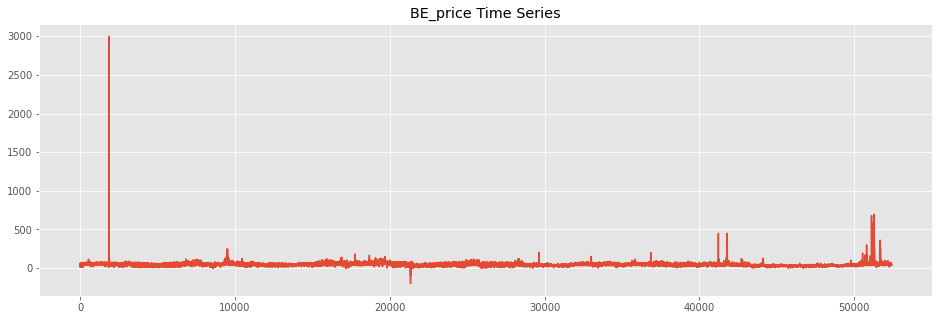

In [7]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("BE_price Time Series")
plt.show()

In [8]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(52416,)

In [9]:
scaled_data = np.transpose(scaled_data)

In [10]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-17472]; out_sample = scaled_data[-17472:]
print(in_sample.shape)
print(in_sample)

(34944,)
[-0.85461707 -0.86148796 -0.86513911 ... -0.84842763 -0.84868396
 -0.84938418]


In [11]:
in_sample = in_sample.reshape(-1,1)
out_sample = out_sample.reshape(-1,1)
print(in_sample)


[[-0.85461707]
 [-0.86148796]
 [-0.86513911]
 ...
 [-0.84842763]
 [-0.84868396]
 [-0.84938418]]


In [12]:
#eemd for in-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)




(34944, 1) (34944, 1)


In [13]:
#eemd for in-sample
imfs1 = eemd(in_sample, t, 9)

print(imfs1.shape)

(10, 34944)


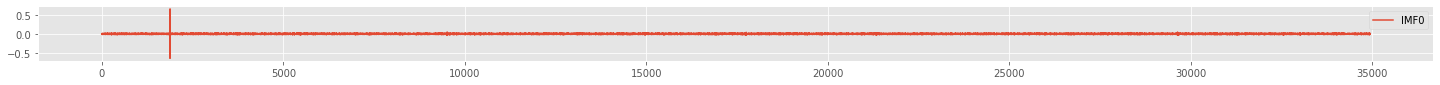

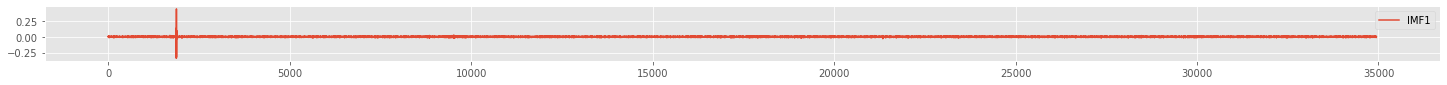

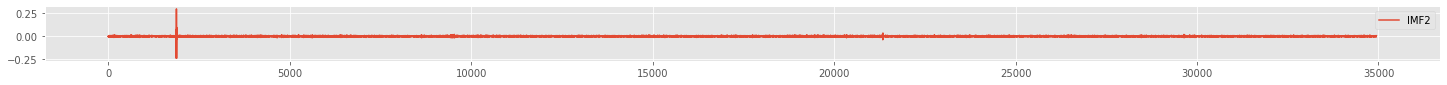

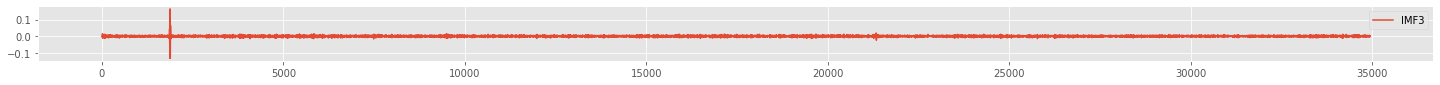

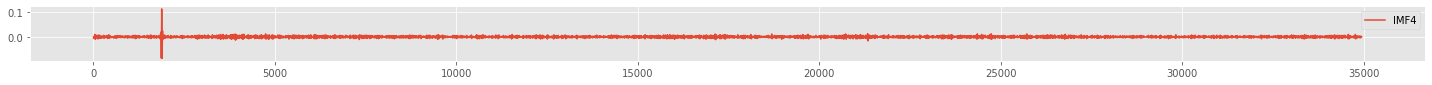

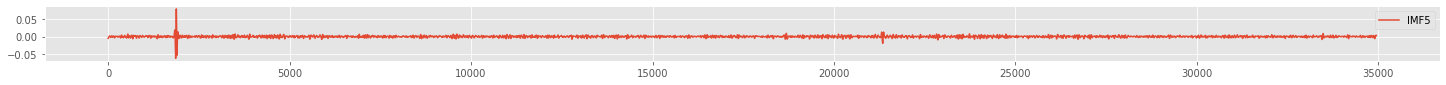

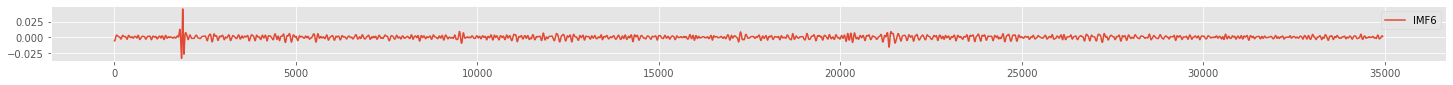

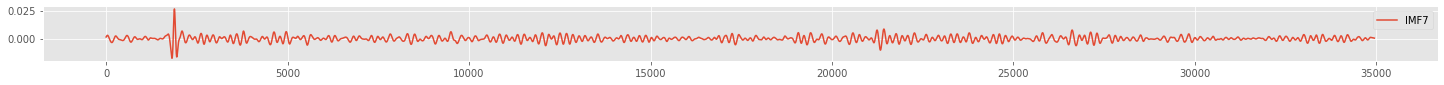

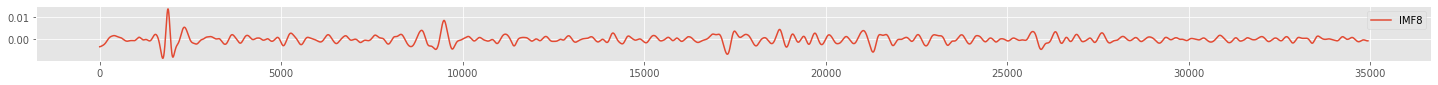

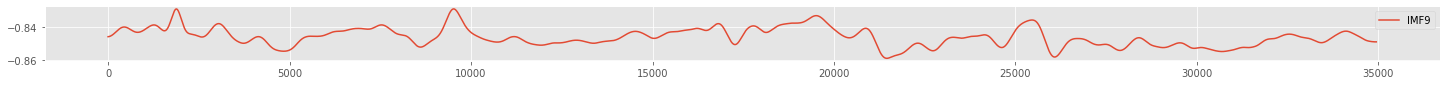

In [15]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

In [16]:
#eemd for out-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, out_sample.shape[0], out_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, out_sample.shape)
t = np.squeeze(t)
out_sample = np.squeeze(out_sample)


(17472, 1) (17472, 1)


In [17]:
#eemd for out-sample
imfs1 = eemd(out_sample, t, 9)

print(imfs1.shape)

(10, 17472)


In [18]:
from pandas import DataFrame


In [19]:
import pandas as pd
pd.DataFrame(imfs1)
decomp=pd.DataFrame(imfs1)
print(decomp)

      0         1         2      ...     17469     17470     17471
0  0.003790 -0.001024 -0.001784  ... -0.000725  0.001370 -0.000516
1  0.002054  0.000784 -0.001483  ... -0.001249 -0.000397 -0.000154
2  0.001007  0.000943  0.000063  ... -0.002081 -0.002428 -0.001727
3 -0.001355 -0.001488 -0.001634  ... -0.000199 -0.000448 -0.000535
4 -0.002522 -0.002625 -0.002673  ... -0.001125 -0.001180 -0.001237
5 -0.002008 -0.002024 -0.002019  ... -0.001230 -0.001203 -0.001168
6 -0.001651 -0.001653 -0.001651  ...  0.000076  0.000066  0.000059
7  0.001414  0.001438  0.001461  ...  0.000235  0.000227  0.000218
8 -0.001120 -0.001121 -0.001121  ... -0.002964 -0.002956 -0.002948
9 -0.848818 -0.848819 -0.848821  ... -0.842706 -0.842705 -0.842704

[10 rows x 17472 columns]


In [21]:
import pandas as pd

#save decomposed data

decomp_df = pd.DataFrame(decomp)
decomp_t=decomp.T

decomp_t.to_csv("decomp_t.csv", header=False, quoting=csv.QUOTE_NONE, escapechar=' ')

print(decomp_t)

              0         1         2  ...         7         8         9
0      0.003790  0.002054  0.001007  ...  0.001414 -0.001120 -0.848818
1     -0.001024  0.000784  0.000943  ...  0.001438 -0.001121 -0.848819
2     -0.001784 -0.001483  0.000063  ...  0.001461 -0.001121 -0.848821
3     -0.001241 -0.003855 -0.000981  ...  0.001485 -0.001121 -0.848823
4      0.003683 -0.002762 -0.001705  ...  0.001508 -0.001121 -0.848824
...         ...       ...       ...  ...       ...       ...       ...
17467  0.001273  0.001114 -0.000347  ...  0.000250 -0.002979 -0.842709
17468 -0.001390 -0.000812 -0.001132  ...  0.000243 -0.002971 -0.842707
17469 -0.000725 -0.001249 -0.002081  ...  0.000235 -0.002964 -0.842706
17470  0.001370 -0.000397 -0.002428  ...  0.000227 -0.002956 -0.842705
17471 -0.000516 -0.000154 -0.001727  ...  0.000218 -0.002948 -0.842704

[17472 rows x 10 columns]


In [22]:
pd.DataFrame(out_sample)
out_sample=pd.DataFrame(out_sample)
print(out_sample)
out_sample.to_csv("origtest.csv", header=False, quoting=csv.QUOTE_NONE, escapechar=' ')

              0
0     -0.852291
1     -0.854780
2     -0.857687
3     -0.858062
4     -0.858056
...         ...
17467 -0.849428
17468 -0.849891
17469 -0.852454
17470 -0.853079
17471 -0.853117

[17472 rows x 1 columns]


In [23]:
decomp_t.to_excel("decomp_t.xlsx")

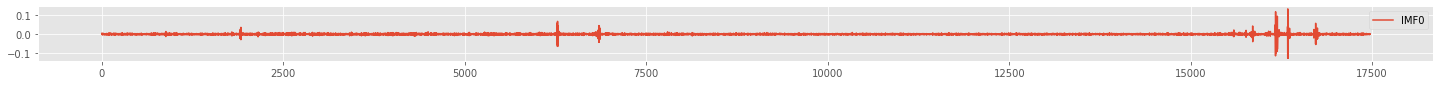

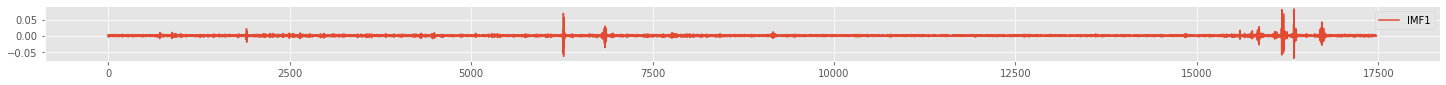

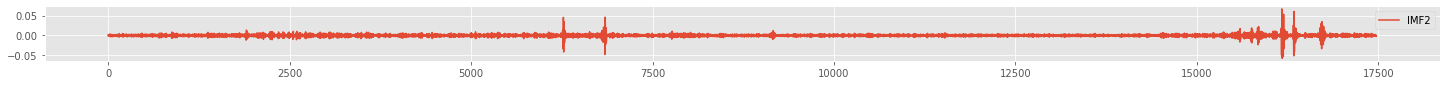

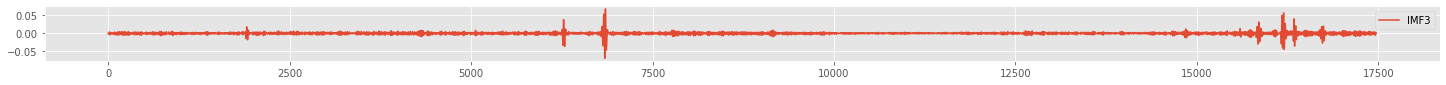

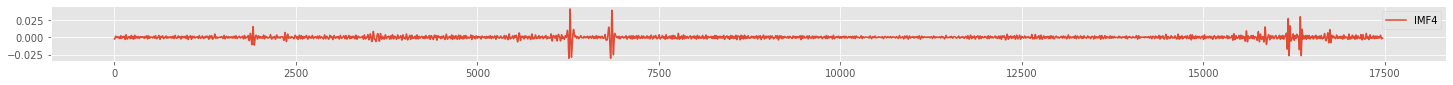

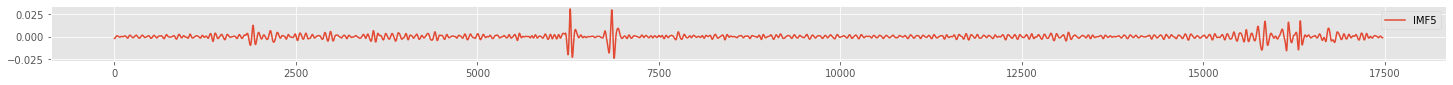

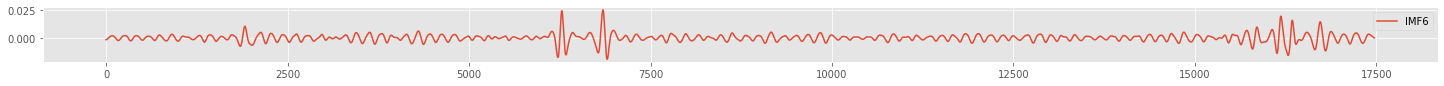

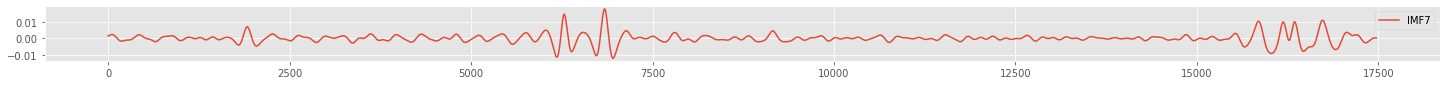

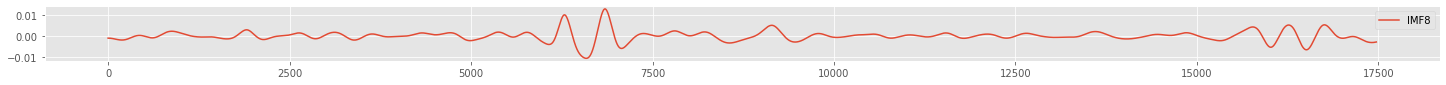

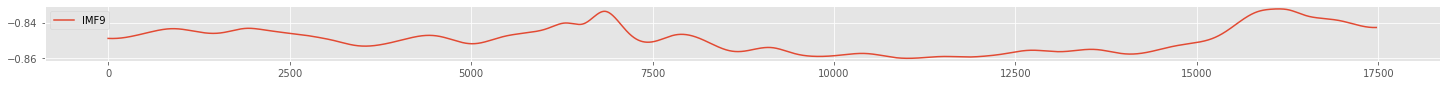

In [24]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.savefig("IMFs.png",dpi=300, bbox_inches='tight',transparent=True)
  
plt.show()
  

In [26]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(34944, 1)
